## Writing Raster Files

For the first example, let's open our Bluemarble dataset and extract a part of it and save it to a new file.
Basically the same we did previously by calling gdal_translate:

    gdal_translate -of GTiff -co TILED=YES -projwin 5.96 47.81 10.49 45.82 geodata/bluemarble.vrt geodata/switzerland.tif


In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

In [2]:
dataset = rasterio.open("geodata/bluemarble.vrt")

Writing a dataset is a little bit more complicated than reading it. We must create a profile containing all information about a file. 

Let's look at the profile of the current dataset:

In [3]:
dataset.profile

{'driver': 'VRT', 'dtype': 'uint8', 'nodata': None, 'width': 86400, 'height': 43200, 'count': 3, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.004166666666666667, 0.0, -180.0,
       0.0, -0.004166666666666667, 90.0), 'blockxsize': 128, 'blockysize': 128, 'tiled': True}

#### Profile Params

We see there are a lot of options in a profile. When writing a dataset we must specify such a profile. The most important options are:

* driver: Name of the Raster Driver (JPEG, GTIFF, VRT, ...)
* dtype: Datatype of each band
* nodata: nodata value(s) or None
* width/height: width/height in pixels
* count: number of bands
* crs: coordinate reference system.
* transform: the Affine transformation
* blockxsize: Blocksize in x direction
* blockysize: Blocksize in y direction
* tiled: True if tiled (always recommended)

Let's read some data (Windowed read).

We want to extract the Bounding Box (5.96,47.81)-(10.49,45.82).

We can convert this to pixels:

In [4]:
~dataset.transform * (5.96, 47.81)

(44630.4, 10125.599999999999)

In [5]:
~dataset.transform * (10.49, 45.82)

(45717.6, 10603.2)

Lets round this up/down using the numpy rint function:

In [6]:
b1 = np.rint(~dataset.transform * (5.96, 47.81))
b2 = np.rint(~dataset.transform * (10.49, 45.82))

print(b1, b2)

[44630. 10126.] [45718. 10603.]


In [7]:
newwidth = int(b2[0]-b1[0])
newheight = int(b2[1]-b1[1])

print(newwidth, newheight)

1088 477


In [8]:
from rasterio.windows import Window

w = Window(b1[0],b1[1],newwidth,newheight)
    
r = dataset.read(1, window=w)
g = dataset.read(2, window=w)
b = dataset.read(3, window=w)

Let's display it just for fun:

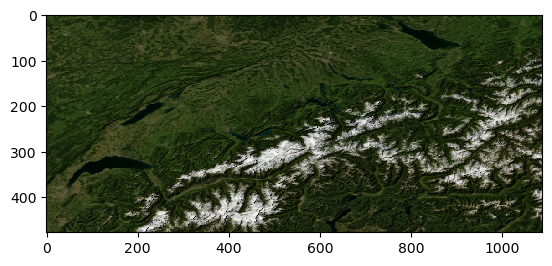

In [9]:
rgb = np.dstack((r,g,b))
fig, ax = plt.subplots()
ax.imshow(rgb, interpolation='nearest');

now we have to calculate the exact coordinate of the top left. Because we extracted rounded before to integers (pixels) we don't really have the original coordinate:

In [10]:
g1 = dataset.transform * b1
g2 = dataset.transform * b2

print(g1,g2)

(5.958333333333343, 47.80833333333334) (10.491666666666674, 45.82083333333333)


Lets calculate the size of one pixel in map coordinates:

In [11]:
pixelsizex = (g2[0]-g1[0])/newwidth
pixelsizey = (g2[1]-g1[1])/newheight

print(pixelsizex, pixelsizey)

0.004166666666666665 -0.004166666666666675


Yes! This is the same as in the original file, we didn't scale anything, so everything is ok. We can create our own transform now:

(assuming we don't have a rotation in our dataset, otherwise we would have to copy them instead of setting 0)

In [12]:
newtransform = rasterio.Affine(pixelsizex, 0.0, g1[0], 0.0, pixelsizey, g1[1])

In [13]:
newtransform

Affine(0.004166666666666665, 0.0, 5.958333333333343,
       0.0, -0.004166666666666675, 47.80833333333334)

And now we can create our new profile:

In [14]:
newprofile = {'driver': 'GTiff', 
              'dtype': 'uint8', 
              'nodata': None, 
              'width': newwidth, 
              'height': newheight, 'count': 3,
              'crs': rasterio.CRS.from_epsg(4326), 
              'transform': newtransform, 
              'blockxsize': 128, 
              'blockysize': 128, 
              'tiled': True}

In [15]:
newdataset = rasterio.open('geodata/writedataset.tif', 'w', **newprofile)

Now we can actually write all bands. Note that "astype" is not really necessary in our case as it is already uint8.

In [16]:
newdataset.write(r.astype(rasterio.uint8), 1)
newdataset.write(g.astype(rasterio.uint8), 2)
newdataset.write(b.astype(rasterio.uint8), 3)

In [17]:
newdataset.close()

In [18]:
dataset.close()

Let's check if everything is fine:

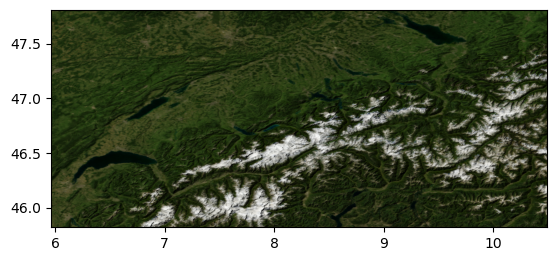

In [19]:
import rasterio.plot

dataset = rasterio.open('geodata/writedataset.tif')
rasterio.plot.show(dataset);

In [20]:
dataset.close()

To check if georeferenciation is correct it is sometimes a good idea to test it in a GIS. I would open it in QGIS and compare it to the original, checking if the position is really correct.
<br/>In our case it is correct!